In [1]:
from cassiemujocoik_ctypes import *
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import time
import array
import numpy as np
import pickle
import os

In [2]:
class CassieIK(object):
    def __init__(self, sim_steps=1, render_sim=True):
        self.sim = mujSimulation(render_sim)
        self.sim_steps = sim_steps
        self.render_sim = render_sim
        # qpos we want as output from ik
        self.qpos = array.array('d', [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        self.qpos = (ctypes.c_double * 35) (*self.qpos)

    def single_pos_ik(self, traj_pos):
        # foot position we want to go to
        traj_pos_arr = array.array('d', traj_pos)
        # convert foot positions to c array
        traj_pos_arr_c = (ctypes.c_double * 9) (*traj_pos_arr)

        # use wrapper to get ik
        qpos = self.sim.fetch_cassie_ik(traj_pos_arr_c, steps=self.sim_steps)

        return np.array(qpos[:35])
    
    def trajectory_ik(self, trajectory):
        traj_qpos = np.zeros((len(trajectory), 35))
        for i in range(len(trajectory)):
            traj_qpos[i] += self.single_pos_ik(trajectory[i])
        
        # Now we gotta estimate the qvels using finite difference estimates of d qpos / dt
        # only do this for the motor positions
        motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]
        traj_qvel = np.zeros((len(trajectory), len(motor_indices)))
        for i in range(len(traj_qpos)):
            traj_qvel[i] += np.take((traj_qpos[i] - traj_qpos[i - 1]) / (1/2000), motor_indices)

        full_trajectory = {"qpos": traj_qpos, "qvel": traj_qvel}
        with open("trajectory/spline_stepping_traj.pkl", "wb") as f:
            pickle.dump(full_trajectory, f)
            print("wrote pickle file")
            
        return traj_qpos, traj_qvel
    
    # version of above function for trajectories from aslip rom
    def rom_trajectory_ik_interpolate(self, spline_params, step_size=0.001, speedup = 3):
        
        # calculate length based on step_size
        points = np.linspace(0, 1, 1682)
#         points = np.arange(0, 1, step_size * speedup)
        new_points = np.transpose(np.array(splev(points, spline_params)))
        print("New points shape = {}".format(new_points.shape))
        length = points.shape[0]
        
        new_points[:,-1] += 0.1
        
        traj_qpos = np.zeros((length, 35))
        
        # variables to hold current phase, time, integer index counter
        time = 0
        
        for i in range(length):    
            # pass traj data from spline into ik
            traj_qpos[i] += self.single_pos_ik(new_points[i])
            # increment time
            time += step_size * speedup
            # debug
            print("time: {}  idx: {}".format(time, i))
            
        # Now we gotta estimate the qvels using finite difference estimates of d qpos / dt
        # only do this for the motor positions
        motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]
        traj_qvel = np.zeros((length, len(motor_indices)))
        for i in range(len(traj_qpos)):
            traj_qvel[i] += np.take((traj_qpos[i] - traj_qpos[i - 1]) / (step_size * speedup), motor_indices)

            
        print("COM Z", new_points[:,2])
        print("left Z", new_points[:-1])
        # calculate distance between feet and center of mass, append to trajectory info
        right_foot = new_points[:,3:6] - new_points[:,6:9]
        left_foot = new_points[:,0:3] - new_points[:,6:9]
            
        return traj_qpos, traj_qvel, right_foot, left_foot

In [3]:
def get_trajectory_from_rom_data():
    data = np.load("rom_traj_data.npy")
    return data

(10, 392)
(9, 392)
(1, 392)


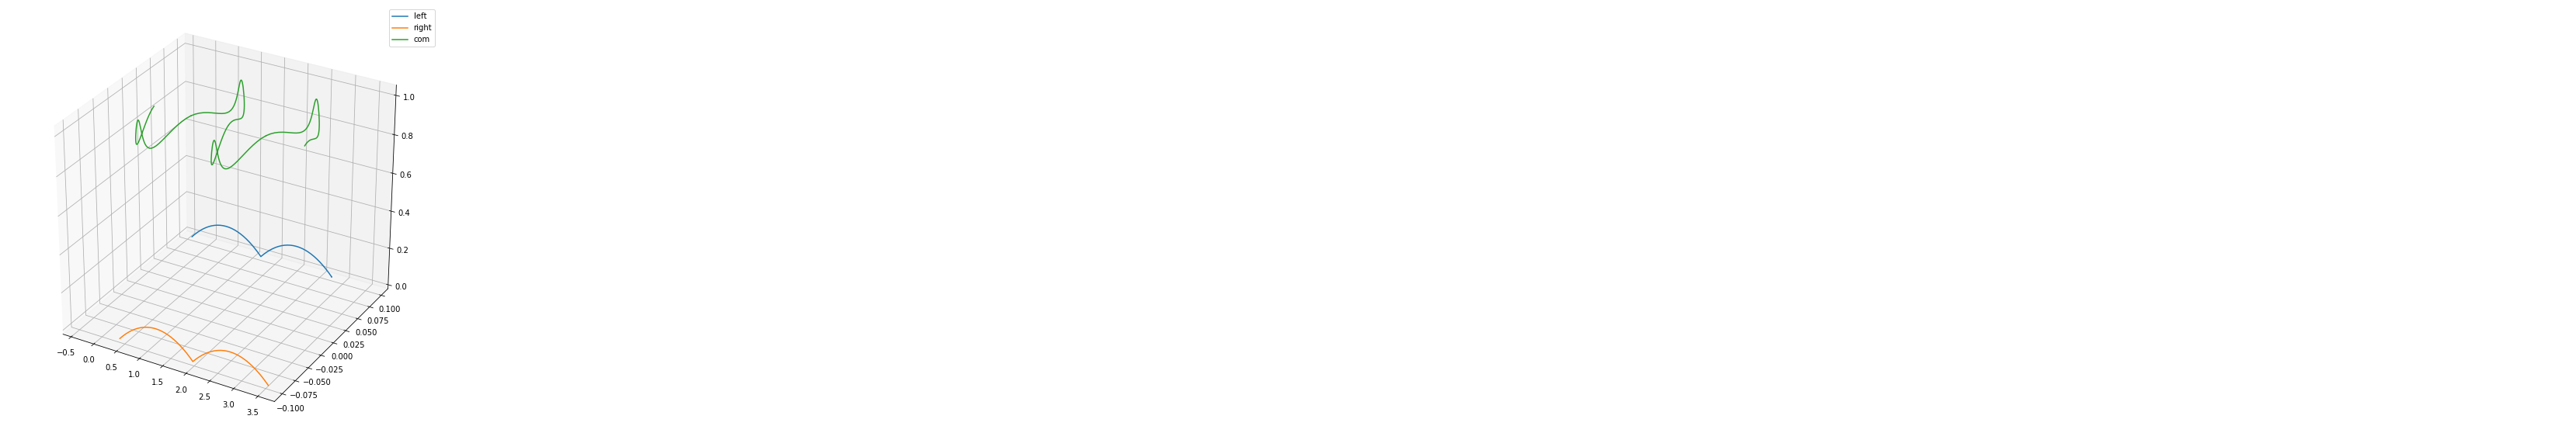

In [4]:
from mpl_toolkits.mplot3d import Axes3D

#task_trajectory = get_trajectory_from_ref_foot_pos()
#task_trajectory = get_trajectory_from_cubic_spline(.2, 1.0, 825)

# rom_trajectory = get_trajectory_from_rom_data() # last row of this data is the time information
rom_trajectory = np.load("/home/drl/yeshg/rom_trajectory_learning/ik/rom_to_taskspace/rom_processed/rom_traj_data_0.8.npy")
print(rom_trajectory.shape)
task_trajectory = rom_trajectory[0:9]
print(task_trajectory.shape)

# generate splines out of task trajecotry
from scipy.interpolate import splprep, splev

tck, u = splprep(task_trajectory, s=0)
new_points = splev(u, tck)

task_trajectory_time = rom_trajectory[9:]
print(task_trajectory_time.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(task_trajectory[0,:],task_trajectory[1,:],task_trajectory[2,:], label='left')
ax.plot(task_trajectory[3,:],task_trajectory[4,:],task_trajectory[5,:], label='right')
ax.plot(task_trajectory[6,:],task_trajectory[7,:],task_trajectory[8,:], label='com')
ax.legend()
plt.show()

cassie = CassieIK(sim_steps=1, render_sim=True)
# traj_qpos, traj_qvel, right_foot, left_foot = cassie.rom_trajectory_ik_interpolate(tck, step_size=0.0001, speedup=6)

# print(right_foot.shape)

# speed = "not"

# full_trajectory = {"qpos": traj_qpos[(traj_qpos.shape[0] // 2):] \
#                    , "qvel": traj_qvel[(traj_qvel.shape[0] // 2):] \
#                    , "rfoot": right_foot[(right_foot.shape[0] // 2):] \
#                    , "lfoot": left_foot[(left_foot.shape[0] // 2):]}
# with open("trajectory/walkCycle_{}.pkl".format(speed), "wb") as f:
#     pickle.dump(full_trajectory, f)
#     print("wrote pickle file")

In [5]:
plt.plot(left_foot[:,0])

NameError: name 'left_foot' is not defined

In [ ]:
# # before interpolate
# fig1 = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(231)
# ax2 = fig.add_subplot(232)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234, sharex=ax1, sharey=ax1)
# ax5 = fig.add_subplot(235, sharex=ax2, sharey=ax2)
# ax6 = fig.add_subplot(236, sharex=ax3, sharey=ax3)
# ax1.plot(task_trajectory[0,:] - task_trajectory[6,:], label='left_x')
# ax2.plot(task_trajectory[1,:] - task_trajectory[7,:], label='left_y')
# ax3.plot(task_trajectory[2,:] - task_trajectory[8,:], label='left_z')
# ax4.plot(task_trajectory[3,:] - task_trajectory[6,:], label='right_x')
# ax5.plot(task_trajectory[4,:] - task_trajectory[7,:], label='right_y')
# ax6.plot(task_trajectory[5,:] - task_trajectory[8,:], label='right_z')
# ax1.legend()
# ax2.legend()
# ax3.legend()
# ax4.legend()
# ax5.legend()
# ax6.legend()
# plt.show()

# after interpolate
fig2 = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234, sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(235, sharex=ax2, sharey=ax2)
ax6 = fig.add_subplot(236, sharex=ax3, sharey=ax3)
ax1.plot(left_foot[:,0], label='left_x')
ax2.plot(left_foot[:,1], label='left_y')
ax3.plot(left_foot[:,2], label='left_z')
ax4.plot(right_foot[:,0], label='right_x')
ax5.plot(right_foot[:,1], label='right_y')
ax6.plot(right_foot[:,2], label='right_z')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.show()


In [ ]:
# Stack data together

print(traj_qpos.shape)

output = np.transpose(np.vstack((sin, cos)))
output = np.hstack((output[(output.shape[0] // 2): , :], traj_qpos[(traj_qpos.shape[0] // 2): , :], traj_qvel[(traj_qvel.shape[0] // 2): , :]))
print(output.shape)

# write to output file
np.save('trajectory/rom_ik_traj_data.npy',output)

In [ ]:
fig = plt.figure(figsize=(12,10))
qposes = fig.add_subplot(111)
#qposes.plot(output[:,:37])
qposes.plot(np.rad2deg(traj_qpos[:,34]))
qposes.plot(np.rad2deg(traj_qpos[:,20]))

plt.show()

In [ ]:
fig2 = plt.figure(figsize=(12,10))
qvels = fig2.add_subplot(111)
qvels.plot(traj_qvel)
qvels.legend(np.arange(10))
plt.show()

In [ ]:
from trajectory import CassieTrajectory
traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")

In [ ]:
# Get actual qpos
motor_indices = [7, 8, 9, 14, 20, 21, 22, 23, 28, 34]

# Plot alongside the IK ones
plt.figure(1, figsize=(12,10))
ik = plt.subplot(211)
plt.plot(traj_qpos[:,np.array(motor_indices)])
plt.legend(np.arange(10))
real = plt.subplot(212)
plt.plot(traj.qpos[:,np.array(motor_indices)])
plt.legend(np.arange(10))
plt.show()




In [ ]:
# Get actual qvels
from trajectory import CassieTrajectory
traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")
motor_indices = [6, 7, 8, 12, 18, 19, 20, 21, 25, 31]
real_qvels = traj.qvel[:,np.array(motor_indices)]

# Plot alongside the calculated ones
plt.figure(1, figsize=(12,10))
calc = plt.subplot(211)
plt.plot(traj_qvel)
plt.legend(np.arange(10))
real = plt.subplot(212)
plt.plot(real_qvels)
plt.legend(np.arange(10))
real.set_xlim(calc.get_xlim())
real.set_ylim(calc.get_ylim())
plt.show()


In [ ]:
# # From cubic spline for now
# from scipy.interpolate import CubicSpline

# def get_trajectory_from_cubic_spline(peak, stride, phase, stance=0.15):
#     """
#     Foot and center of mass trajectory generator

#     The center of mass trajectory is a line q(t) = (x(t), 0, z). 

#     The foot trajectories are periodic 3 point cubic splines in z(t),
#     lines in x(t), and constant in y => q(t) = (x(t), y, z(t))

#     Left and right foot trajectories are offset in time by "phase" timesteps.
#     """
#     # TODO: figure out formula for how com_vel relates to foot trajectories...
#     # is SLIP model necessary?
#     com_vel = 0.02

#     t = np.arange(phase)

#     m = stride / phase

#     ts = np.array([0, phase / 2, phase - 1])
#     zs = np.array([0, peak, 0])
#     spline = CubicSpline(ts, zs)

#     x = m * t
#     z = spline(t)
    
#     # left foot steps first
#     x_l = np.concatenate((x, np.ones(phase) * x[-1]))
#     y_l = np.ones(phase * 2) * -stance
#     z_l = np.concatenate((z, np.zeros(phase)))

#     # then right foot
#     x_r = np.concatenate((np.ones(phase) * x[0] + stride / 2, x + stride / 2))
#     y_r = np.ones(phase * 2) * stance
#     z_r = np.concatenate((np.zeros(phase), z))

#     x_com = np.cumsum(np.ones(phase * 2) * com_vel)
#     y_com = np.zeros(phase * 2)
#     z_com = np.ones(phase * 2) * 1

#     return np.column_stack([x_l, y_l, z_l, 
#                        x_r, y_r, z_r, 
#                        x_com, y_com, z_com])

In [ ]:
# def get_trajectory_from_ref_foot_pos():
#     from trajectory import CassieTrajectory
#     traj = CassieTrajectory("helei_reference_foot_data/stepdata.bin")

#     os.path.abspath('')
#     foot_pos = traj.foot_pos
#     foot_vel = traj.foot_vel

#     com_vel = 0.02

#     pelvis_height = 1

#     # pelvis coordinates
#     x_com = traj.qpos[:,0]
#     y_com = traj.qpos[:,1]
#     z_com = traj.qpos[:,2]

#     # left foot steps first
#     x_l = foot_pos[:,0] + x_com
#     y_l = foot_pos[:,1] + y_com
#     z_l = foot_pos[:,2] + z_com

#     # then right foot
#     x_r = foot_pos[:,3] + x_com
#     y_r = foot_pos[:,4] + y_com
#     z_r = foot_pos[:,5] + z_com

#     return np.column_stack([x_l, y_l, z_l, 
#                        x_r, y_r, z_r, 
#                        x_com, y_com, z_com])

In [ ]:
# Finally, let's create a clock to add to final data.

def generate_clock(data_len):
    x = np.arange(0, 2 * np.pi, 2*np.pi / data_len)
    return np.sin(x), np.cos(x)

sin, cos = generate_clock(traj_qpos.shape[0])

# plots of individual rows
fig = plt.figure()
ax = fig.add_subplot(111)

# graph sin, cos
ax.plot(sin,label='sin')
ax.plot(cos,label='cos')
ax.legend()

plt.show()